In [1]:
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import rasterio
from rasterio.plot import show

print("Root directory:", os.getcwd())

Root directory: D:\RSCode\Cross-Modal-Learning


In [2]:
s2_folder = "D:\RSCode\BigEarthNet-S2"
s1_folder = "D:\RSCode\BigEarthNet-S1"

# Sentinel-1

The BigEarthNet-S1 directory has one directory per Sentinel-1 source tile (in total 312) and a
dedicated directory for each individual patch. Each patch directory contains the GeoTIFF files for
the individual bands.

In [3]:
s1_tiles = [folder for folder in os.listdir(s1_folder)] 
s1_tile_sample_patch = [folder for folder in os.listdir(os.path.join(s1_folder, s1_tiles[0]))]

print("Number of tiles:", len(s1_tiles), "\nNumber of patches in a source tile:", len(s1_tile_sample_patch))

Number of tiles: 312 
Number of patches in a source tile: 1699


VV Polarization (Vertical Transmit and Vertical Receive) is sensitive to vertically oriented structures and surfaces. For example, it responds well to flat surfaces like calm water bodies and canopies of trees or crops.

VH Polarization (Vertical Transmit and Horizontal Receive) is more sensitive to complex and rough surfaces that cause depolarization of the radar signal. It captures more information from surfaces that scatter the radar wave in multiple directions, such as vegetation, rough terrain, and heterogeneous surfaces.

In [4]:
s1_tiff_files = [file for file in os.listdir(os.path.join(s1_folder, s1_tiles[0], s1_tile_sample_patch[0]))]
print(s1_tiff_files)

['S1A_IW_GRDH_1SDV_20170613T165043_33UUP_61_39_VH.tif', 'S1A_IW_GRDH_1SDV_20170613T165043_33UUP_61_39_VV.tif']


In [5]:
with rasterio.open(os.path.join(s1_folder, s1_tiles[0], s1_tile_sample_patch[0], s1_tiff_files[0])) as src:
    sample_VH = src.read() 
with rasterio.open(os.path.join(s1_folder, s1_tiles[0], s1_tile_sample_patch[0], s1_tiff_files[1])) as src:
    sample_VV = src.read() 

print("VV band shape: ", sample_VV.shape)
print("VH band shape: ", sample_VH.shape)

VV band shape:  (1, 120, 120)
VH band shape:  (1, 120, 120)


# Sentinel-2

The BigEarthNet-S2 directory has one directory per Sentinel-2 source tile (in total 115) and a
dedicated directory for each individual patch. Each patch directory contains the GeoTIFF files for
the individual bands.

In [6]:
s2_tiles = [folder for folder in os.listdir(s2_folder)] 
s2_tile_sample_patch = [folder for folder in os.listdir(os.path.join(s2_folder, s2_tiles[0]))]

print("Number of tiles:", len(s2_tiles), "\nNumber of patches in a source tile:", len(s2_tile_sample_patch))

Number of tiles: 115 
Number of patches in a source tile: 3305


In [7]:
s2_tiff_files = [file for file in os.listdir(os.path.join(s2_folder, s2_tiles[0], s2_tile_sample_patch[0]))]

#https://gisgeography.com/sentinel-2-bands-combinations
band_resolutions = [60, 10, 10, 10, 20, 20, 20, 10, 60, 20, 20, 20] 

print('Band \t Resolution \n')
for i in range(len(s2_tiff_files)):
    print(s2_tiff_files[i][-7:-4], '\t', band_resolutions[i], 'm', '\n')

Band 	 Resolution 

B01 	 60 m 

B02 	 10 m 

B03 	 10 m 

B04 	 10 m 

B05 	 20 m 

B06 	 20 m 

B07 	 20 m 

B08 	 10 m 

B09 	 60 m 

B11 	 20 m 

B12 	 20 m 

B8A 	 20 m 



# Metadata Analysis

In [9]:
#!pip install pandas pyarrow
metadata_path = "D:\RSCode\metadata.parquet"

In [10]:
df = pd.read_parquet(metadata_path)

In [11]:
list(df.columns)

['patch_id',
 'labels',
 'split',
 'country',
 's1_name',
 's2v1_name',
 'contains_seasonal_snow',
 'contains_cloud_or_shadow']

In [22]:
df[df['contains_cloud_or_shadow']==True].head() 

,patch_id,labels,split,country,s1_name,s2v1_name,contains_seasonal_snow,contains_cloud_or_shadow


In [6]:
df[df['split'] == 'train'].groupby(['country']).count()

,patch_id,labels,split,s1_name,s2v1_name,contains_seasonal_snow,contains_cloud_or_shadow
country,,,,,,,
Austria,24972,24972,24972,24972,24972,24972,24972
Belgium,7837,7837,7837,7837,7837,7837,7837
Finland,74293,74293,74293,74293,74293,74293,74293
Ireland,22482,22482,22482,22482,22482,22482,22482
Kosovo,849,849,849,849,849,849,849
Lithuania,23170,23170,23170,23170,23170,23170,23170
Luxembourg,1888,1888,1888,1888,1888,1888,1888
Portugal,43721,43721,43721,43721,43721,43721,43721
Serbia,36967,36967,36967,36967,36967,36967,36967


In [12]:
# Portugal for subsampling

s2_corr_s1 = df[["patch_id", "s1_name", "labels", "split", "country"]]
portugal_df = s2_corr_s1[s2_corr_s1['country'] == 'Portugal']
portugal_df = portugal_df[["patch_id", "s1_name", "labels", "split"]]

print("Number of Patches Portugal: " ,len(portugal_df))
portugal_df.head()

Number of Patches Portugal:  89792


,patch_id,s1_name,labels,split
24732,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_0,"[Coniferous forest, Transitional woodland, shrub]",train
24733,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_1,"[Coniferous forest, Transitional woodland, shrub]",train
24734,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_2,"[Coniferous forest, Transitional woodland, shrub]",train
24735,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_3,"[Coniferous forest, Transitional woodland, shrub]",train
24736,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_4,"[Coniferous forest, Transitional woodland, shr...",train


In [8]:
s2_corr_s1['split'].unique()

array(['test', 'validation', 'train'], dtype=object)

In [15]:
'''
train_df = s2_corr_s1[s2_corr_s1['split'] == 'train']
test_df = s2_corr_s1[s2_corr_s1['split'] == 'test']

'''
train_portugal_df = portugal_df[(portugal_df["split"] == "train")]
test_portugal_df = portugal_df[(portugal_df["split"] == "test")]
train_portugal_df = train_portugal_df[["patch_id", "s1_name", "labels"]]
test_portugal_df = test_portugal_df[["patch_id", "s1_name", "labels"]]

print("Number of Patches Train Portugal: " ,len(train_portugal_df))
print("Number of Patches Test Portugal: " ,len(test_portugal_df))
train_portugal_df.head()

Number of Patches Train Portugal:  43721
Number of Patches Test Portugal:  23209


,patch_id,s1_name,labels
24732,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_0,"[Coniferous forest, Transitional woodland, shrub]"
24733,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_1,"[Coniferous forest, Transitional woodland, shrub]"
24734,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_2,"[Coniferous forest, Transitional woodland, shrub]"
24735,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_3,"[Coniferous forest, Transitional woodland, shrub]"
24736,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_4,"[Coniferous forest, Transitional woodland, shr..."


# Images

All of the patches in the table are suitable for scene classification. Work will be with a subset of the whole dataset and the corresponding patches of S2 and S1 datasets should be stacked together to create a 14 band data with the shape (14, 120, 120).

Sentinel-1 bands: (VV, VH)

Sentinel-2 bands: (B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12)

All bands: (VV, VH, B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12)

# Labels

19-class nomenclature

https://docs.kai-tub.tech/ben-docs/labels.html#id3



# Data Preprocessing

In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
# indicator should be 3 for s1 and 2 for s2 due to a difference in folder structure between them
def extract_tile_from_patch(patch, indicator):
    parts = patch.split('_')
    tile = '_'.join(parts[:-indicator])
    return tile

In [ ]:
# HISTOGRAMS FOR BAND NORMALIZATION 

43721it [12:16, 59.36it/s]


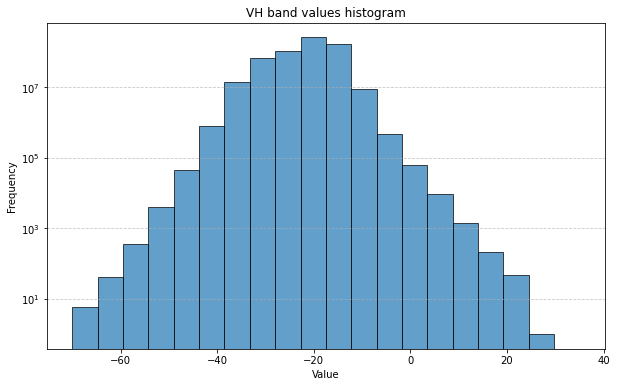

In [76]:
num_bins = 20
hist_bins = np.linspace(-80, 30, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_VH.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s1_patch = row['s1_name']
    s1_tile = extract_tile_from_patch(s1_patch, 3) 
    s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('VH band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [17:56, 40.60it/s]


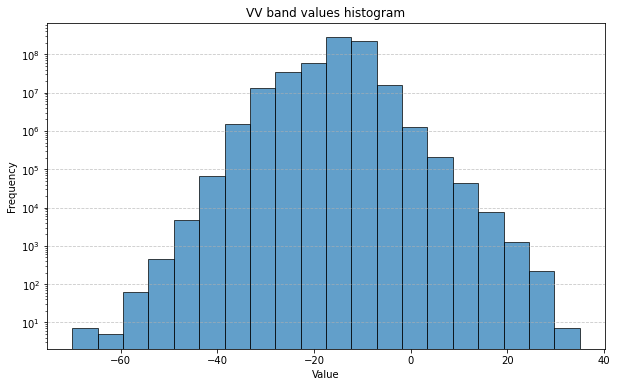

In [118]:
num_bins = 20
hist_bins = np.linspace(-70, 35, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_VV.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s1_patch = row['s1_name']
    s1_tile = extract_tile_from_patch(s1_patch, 3) 
    s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('VV band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:25, 58.68it/s]


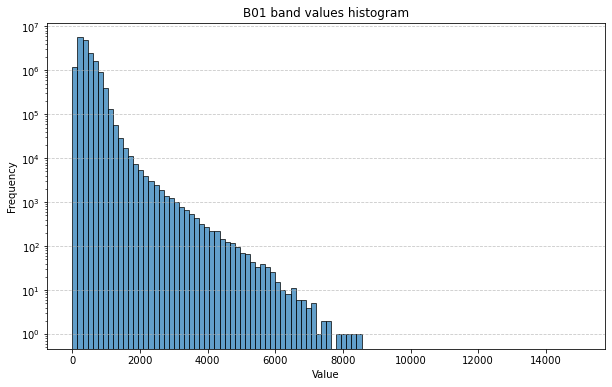

In [45]:
num_bins = 100
hist_bins = np.linspace(1, 15000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B01.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B01 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:27, 58.49it/s]


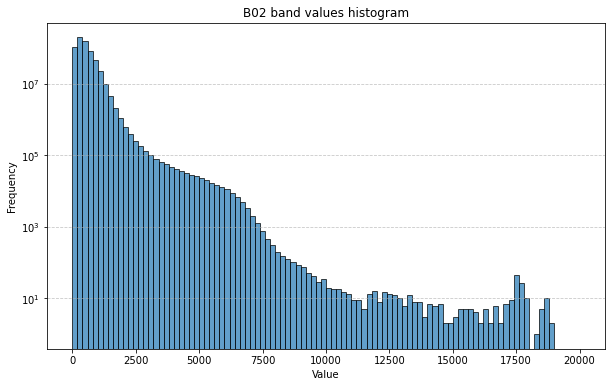

In [46]:
num_bins = 100
hist_bins = np.linspace(1, 20000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B02.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B02 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:22, 58.88it/s]


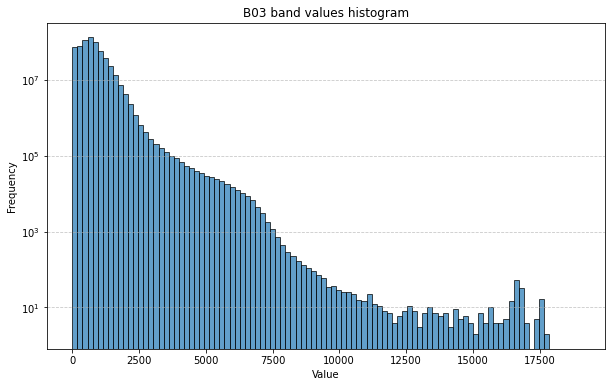

In [47]:
num_bins = 100
hist_bins = np.linspace(1, 19000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B03.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B03 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [13:21, 54.58it/s]


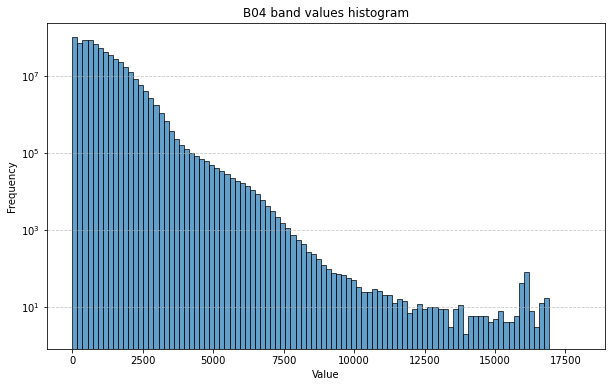

In [48]:
num_bins = 100
hist_bins = np.linspace(1, 18000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B04.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B04 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [15:13, 47.85it/s]


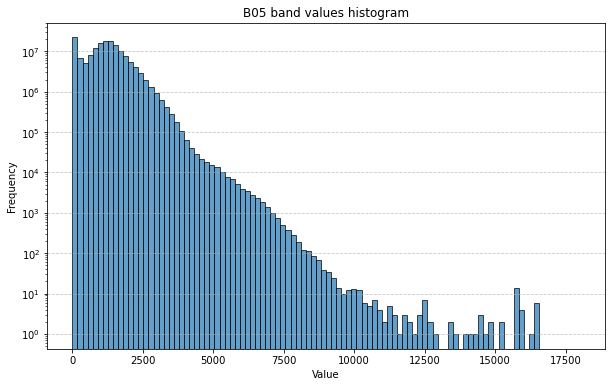

In [49]:
num_bins = 100
hist_bins = np.linspace(1, 18000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B05.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B05 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:10, 59.89it/s]


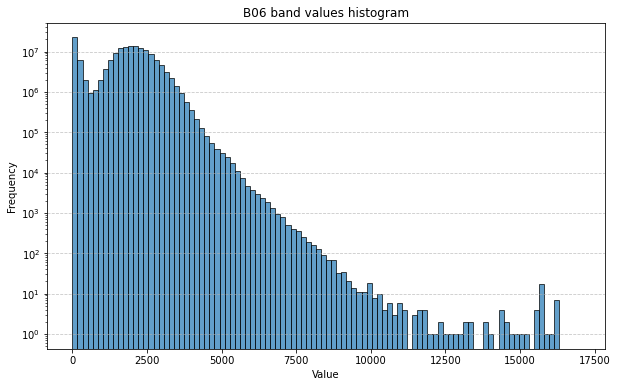

In [50]:
num_bins = 100
hist_bins = np.linspace(1, 17000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B06.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B06 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:12, 59.72it/s]


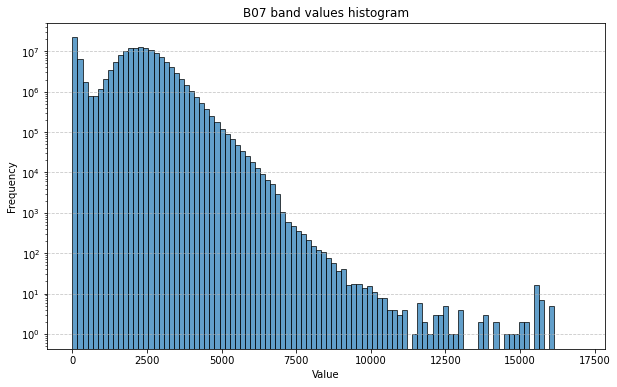

In [51]:
num_bins = 100
hist_bins = np.linspace(1, 17000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B07.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B07 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:31, 58.15it/s]


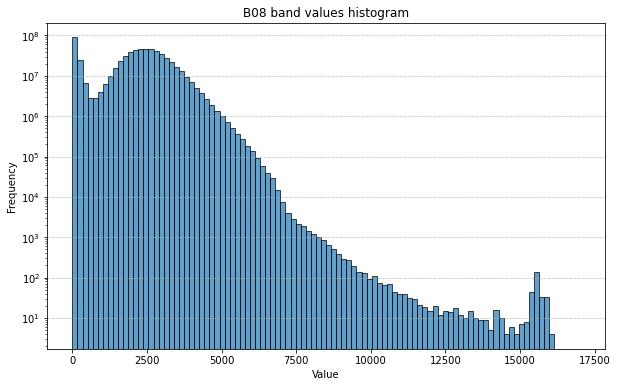

In [53]:
num_bins = 100
hist_bins = np.linspace(1, 17000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B08.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B08 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [12:13, 59.61it/s]


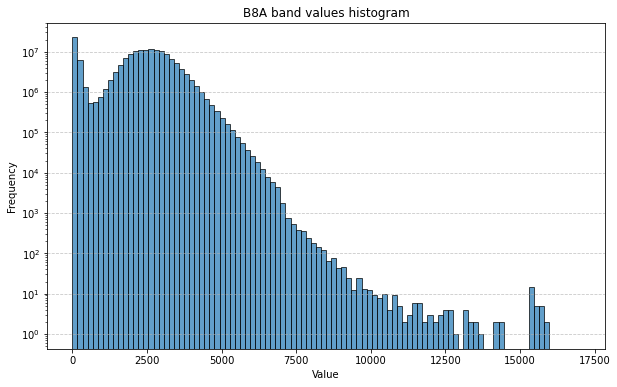

In [54]:
num_bins = 100
hist_bins = np.linspace(1, 17000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B8A.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B8A band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [11:42, 62.22it/s]


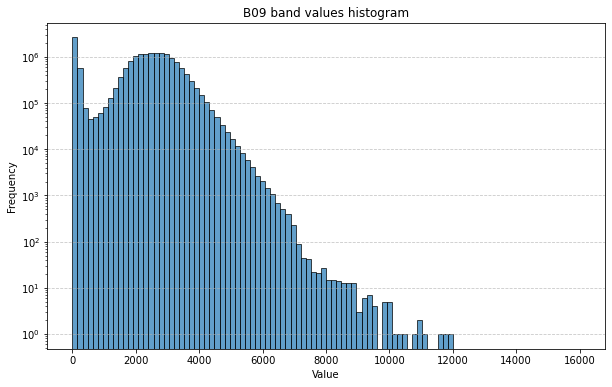

In [55]:
num_bins = 100
hist_bins = np.linspace(1, 16000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B09.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B09 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [11:30, 63.32it/s]


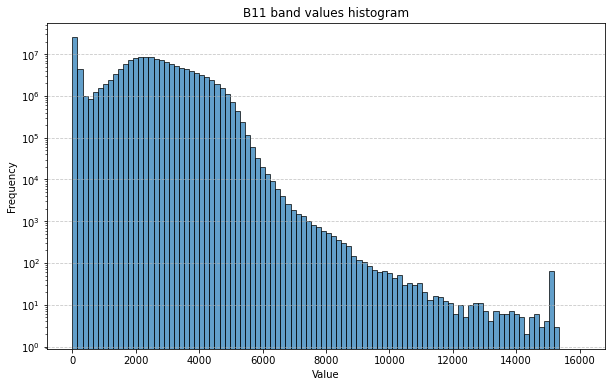

In [56]:
num_bins = 100
hist_bins = np.linspace(1, 16000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B11.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B11 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

43721it [11:47, 61.77it/s]


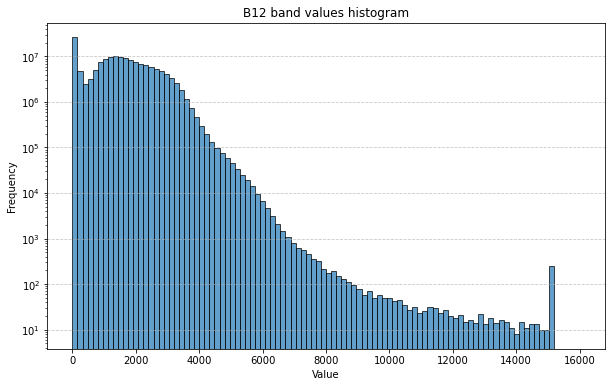

In [57]:
num_bins = 100
hist_bins = np.linspace(1, 16000, num_bins + 1)  # Define bin edges for each band individually
hist_counts = np.zeros(num_bins)
band_string = '_B12.tif'
for _, row in tqdm(train_portugal_df.iterrows()):
    s2_patch = row['patch_id']
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + band_string)) as src:
        band = src.read()
        band = band.squeeze().flatten()
        counts, _ = np.histogram(band, bins=hist_bins)
        
        hist_counts += counts
        
# accumulated histogram
plt.figure(figsize=(10, 6))
plt.bar(hist_bins[:-1], hist_counts, width=(hist_bins[1] - hist_bins[0]), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('B12 band values histogram')
plt.yscale('log')  # log scale for better visibility of outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
# TESTING SCIPY ZOOM
# Result: to preserve spectral integrity and retain as close as possible the original radiance or reflectance values 
# use nearest neighbor resampling
import scipy
from scipy.ndimage import zoom 

447 4583


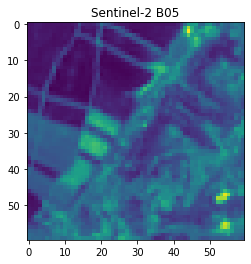

In [22]:
b05_sample = 'D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32_B05.tif'

with rasterio.open(b05_sample) as src:
    b05 = src.read()
    plt.imshow(normalize_to_rgb(b05.squeeze()))
    print(b05.min(), b05.max())
    plt.title("Sentinel-2 B05")
    plt.show()

447 4583


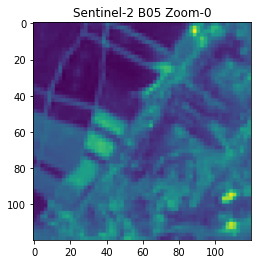

In [23]:
b05_sample = 'D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32_B05.tif'

with rasterio.open(b05_sample) as src:
    b05 = src.read()
    b05 = zoom(b05.squeeze(), 2, order=0)
    print(b05.min(), b05.max())    
    plt.imshow(normalize_to_rgb(b05))
    plt.title("Sentinel-2 B05 Zoom-0")
    plt.show()    

488 4399


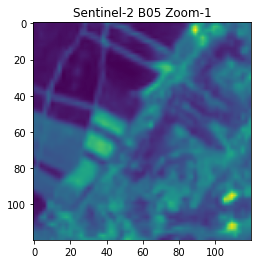

In [24]:
b05_sample = 'D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32_B05.tif'

with rasterio.open(b05_sample) as src:
    b05 = src.read()
    b05 = zoom(b05.squeeze(), 2, order=1)
    print(b05.min(), b05.max())    
    plt.imshow(normalize_to_rgb(b05))
    plt.title("Sentinel-2 B05 Zoom-1")
    plt.show()    

417 4551


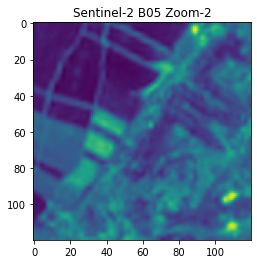

In [25]:
b05_sample = 'D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32_B05.tif'

with rasterio.open(b05_sample) as src:
    b05 = src.read()
    b05 = zoom(b05.squeeze(), 2, order=2)
    print(b05.min(), b05.max())
    plt.imshow(normalize_to_rgb(b05))
    plt.title("Sentinel-2 B05 Zoom-2")
    plt.show()    

411 4546


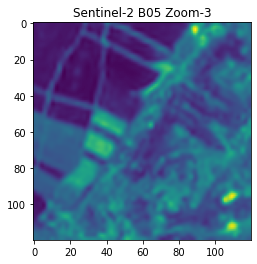

In [26]:
b05_sample = 'D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32\S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_40_32_B05.tif'

with rasterio.open(b05_sample) as src:
    b05 = src.read()
    b05 = zoom(b05.squeeze(), 2, order=3)
    print(b05.min(), b05.max())    
    plt.imshow(normalize_to_rgb(b05))
    plt.title("Sentinel-2 B05 Zoom-3")
    plt.show()    

In [17]:
# the dataset includes negative values, which indicates they are in db-scale. Should be normalized to [-1, 1] range.
# for normalization (no matter whether min-max or mean-stddev) the global values of the (train) dataset should be used.

def normalize_min_max(arr, min_val, max_val):
    return 2 * ((arr - min_val) / (max_val - min_val)) - 1

def normalize_mean_stddev(arr, mean_val, stddev_val):
    return (arr-mean) / std_dev

def normalize_to_rgb(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val)

# https://developers.google.com/earth-engine/datasets/catalog/TUBerlin_BigEarthNet_v1#bands
# the link above indicates that all bands should be scaled with 0.0001

'''
Since there's no snow in the dataset, the high values in the tail are more likely due to sensor noise, 
artifacts, or specific regions with very bright reflectance, such as urban areas or areas with high albedo.
Therefore clipping to 10000 is meaningful for sentinel 2 bands

For sentinel 1 values are clipped to range [-60, 25]
'''
def normalize_s2(arr):
    arr = arr / 10000
    np.clip(arr, None, 1, out=arr) # clip bigger values to 1 
    return arr * 2 - 1 

def normalize_s1(arr, min_val, max_val):
    np.clip(arr, min_val, max_val, out=arr)
    arr = 2 * ((arr - min_val) / (max_val - min_val)) - 1
    return arr


In [22]:
normalize_s2(np.array([10020, 21333, 8000, 7500, 240]))

array([ 1.   ,  1.   ,  0.6  ,  0.5  , -0.952])

In [23]:
normalize_s1(np.array([20, 28, -61, -50, 0]), -60, 25)

array([ 0.88235294,  1.        , -1.        , -0.76470588,  0.41176471])

In [18]:
def combine_s2_s1_bands(s2_patch_path, s1_patch_path):
    s1_s2_bands = []
    
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + '_VV.tif')) as src:
        raster_profile = src.profile
        vv = src.read()
        s1_s2_bands.append(normalize_s1(vv.squeeze(), -60, 25))
    with rasterio.open(os.path.join(s1_patch_path, os.path.basename(s1_patch_path) + '_VH.tif')) as src:
        vh = src.read()
        s1_s2_bands.append(normalize_s1(vh.squeeze(), -60, 25))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B01.tif')) as src:
        b01 = src.read()
        b01 = zoom(normalize_s2(b01.squeeze()), 6, order=3)
        s1_s2_bands.append(b01)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B02.tif')) as src:
        b02 = src.read()
        s1_s2_bands.append(normalize_s2(b02.squeeze()))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B03.tif')) as src:
        b03 = src.read()
        s1_s2_bands.append(normalize_s2(b03.squeeze()))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B04.tif')) as src:
        b04 = src.read()
        s1_s2_bands.append(normalize_s2(b04.squeeze()))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B05.tif')) as src:
        b05 = src.read()
        b05 = zoom(normalize_s2(b05.squeeze()), 2, order=3)
        s1_s2_bands.append(b05)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B06.tif')) as src:
        b06 = src.read()
        b06 = zoom(normalize_s2(b06.squeeze()), 2, order=3)
        s1_s2_bands.append(b06)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B07.tif')) as src:
        b07 = src.read()
        b07 = zoom(normalize_s2(b07.squeeze()), 2, order=3)
        s1_s2_bands.append(b07)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B08.tif')) as src:
        b08 = src.read()
        s1_s2_bands.append(normalize_s2(b08.squeeze()))
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B8A.tif')) as src:
        b8a = src.read()
        b8a = zoom(normalize_s2(b8a.squeeze()), 2, order=3)
        s1_s2_bands.append(b8a)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B09.tif')) as src:
        b09 = src.read()
        b09 = zoom(normalize_s2(b09.squeeze()), 6, order=3)
        s1_s2_bands.append(b09)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B11.tif')) as src:
        b11 = src.read()
        b11 = zoom(normalize_s2(b11.squeeze()), 2, order=3)
        s1_s2_bands.append(b11)
    with rasterio.open(os.path.join(s2_patch_path, os.path.basename(s2_patch_path) + '_B12.tif')) as src:
        b12 = src.read()
        b12 = zoom(normalize_s2(b12.squeeze()), 2, order=3)
        s1_s2_bands.append(b12)
        
    s1_s2_bands = np.dstack(s1_s2_bands)
    s1_s2_bands = np.transpose(s1_s2_bands, [2,0,1])
    return s1_s2_bands, raster_profile

In [16]:
s1_s2_raster, _ = combine_s2_s1_bands('D:\RSCode\BigEarthNet-S2\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_00_39',
                                  'D:\RSCode\BigEarthNet-S1\S1A_IW_GRDH_1SDV_20170617T064724\S1A_IW_GRDH_1SDV_20170617T064724_29UPU_0_39')

print("All Bands data shape: ", s1_s2_raster.shape, "\n")
print("Band ", "Min","\t", "Max","\t", "Mean")
print("VV: ", s1_s2_raster[0].min(), "\t", s1_s2_raster[0].max(), "\t", s1_s2_raster[0].mean())
print("VH: ", s1_s2_raster[1].min(), "\t", s1_s2_raster[1].max(), "\t", s1_s2_raster[1].mean())
print("RED:", s1_s2_raster[5].min(), "\t", s1_s2_raster[5].max(), "\t", s1_s2_raster[5].mean())

#https://gis.stackexchange.com/questions/400726/creating-composite-rgb-images-from-sentinel-1-channels
s1_rgb = np.dstack(np.array([s1_s2_raster[0], s1_s2_raster[1], s1_s2_raster[0] - s1_s2_raster[1]]))

#https://gisgeography.com/sentinel-2-bands-combinations
s2_rgb = np.dstack(np.array([s1_s2_raster[5], s1_s2_raster[4], s1_s2_raster[3]]))
s2_agri = np.dstack(np.array([s1_s2_raster[12], s1_s2_raster[9], s1_s2_raster[3]]))
s2_geology = np.dstack(np.array([s1_s2_raster[13], s1_s2_raster[12], s1_s2_raster[3]]))

All Bands data shape:  (14, 120, 120) 

Band  Min 	 Max 	 Mean
VV:  -0.1757604479789734 	 0.7050056457519531 	 0.11142221312556001
VH:  -0.34821420907974243 	 0.4839264154434204 	 -0.01195736687630415
RED: -0.9654 	 -0.3768 	 -0.9040880694444445


In [152]:
", ".join(train_portugal_df.iloc[3210]['labels'][:-1])

'Complex cultivation patterns'

In [24]:
path1_2 = os.path.join(s2_folder, extract_tile_from_patch(train_portugal_df.iloc[163]['patch_id'], 2), train_portugal_df.iloc[163]['patch_id'])
path1_1 = os.path.join(s1_folder, extract_tile_from_patch(train_portugal_df.iloc[163]['s1_name'], 3), train_portugal_df.iloc[163]['s1_name'])
path2_2 = os.path.join(s2_folder, extract_tile_from_patch(train_portugal_df.iloc[18000]['patch_id'], 2), train_portugal_df.iloc[18000]['patch_id'])
path2_1 = os.path.join(s1_folder, extract_tile_from_patch(train_portugal_df.iloc[18000]['s1_name'], 3), train_portugal_df.iloc[18000]['s1_name'])
path3_2 = os.path.join(s2_folder, extract_tile_from_patch(train_portugal_df.iloc[4141]['patch_id'], 2), train_portugal_df.iloc[4141]['patch_id'])
path3_1 = os.path.join(s1_folder, extract_tile_from_patch(train_portugal_df.iloc[4141]['s1_name'], 3), train_portugal_df.iloc[4141]['s1_name'])
path4_2 = os.path.join(s2_folder, extract_tile_from_patch(train_portugal_df.iloc[17500]['patch_id'], 2), train_portugal_df.iloc[17500]['patch_id'])
path4_1 = os.path.join(s1_folder, extract_tile_from_patch(train_portugal_df.iloc[17500]['s1_name'], 3), train_portugal_df.iloc[17500]['s1_name'])
path5_2 = os.path.join(s2_folder, extract_tile_from_patch(train_portugal_df.iloc[2210]['patch_id'], 2), train_portugal_df.iloc[2210]['patch_id'])
path5_1 = os.path.join(s1_folder, extract_tile_from_patch(train_portugal_df.iloc[2210]['s1_name'], 3), train_portugal_df.iloc[2210]['s1_name'])
path6_2 = os.path.join(s2_folder, extract_tile_from_patch(train_portugal_df.iloc[3210]['patch_id'], 2), train_portugal_df.iloc[3210]['patch_id'])
path6_1 = os.path.join(s1_folder, extract_tile_from_patch(train_portugal_df.iloc[3210]['s1_name'], 3), train_portugal_df.iloc[3210]['s1_name'])

raster1, _ = combine_s2_s1_bands(path1_2, path1_1)
raster2, _ = combine_s2_s1_bands(path2_2, path2_1)
raster3, _ = combine_s2_s1_bands(path3_2, path3_1)
raster4, _ = combine_s2_s1_bands(path4_2, path4_1)
raster5, _ = combine_s2_s1_bands(path5_2, path5_1)
raster6, _ = combine_s2_s1_bands(path6_2, path6_1)
i1 = np.dstack(np.array([raster1[0], raster1[1], raster1[0]-raster1[1]]))
i2 = np.dstack(np.array([raster2[0], raster2[1], raster2[0]-raster2[1]]))
i3 = np.dstack(np.array([raster3[0], raster3[1], raster3[0]-raster3[1]]))
i4 = np.dstack(np.array([raster4[0], raster4[1], raster4[0]-raster4[1]]))
i5 = np.dstack(np.array([raster5[0], raster5[1], raster5[0]-raster5[1]]))
i6 = np.dstack(np.array([raster6[0], raster6[1], raster6[0]-raster6[1]]))
images = [i1, i2, i3, i4, i5, i6]
titles = [", ".join(train_portugal_df.iloc[163]['labels']), ", ".join(train_portugal_df.iloc[18000]['labels']), ", ".join(train_portugal_df.iloc[4141]['labels']),
         ", ".join(train_portugal_df.iloc[17500]['labels'][:-1]), ", ".join(train_portugal_df.iloc[2210]['labels'][:-1]), ", ".join(train_portugal_df.iloc[3210]['labels'][:-1])]

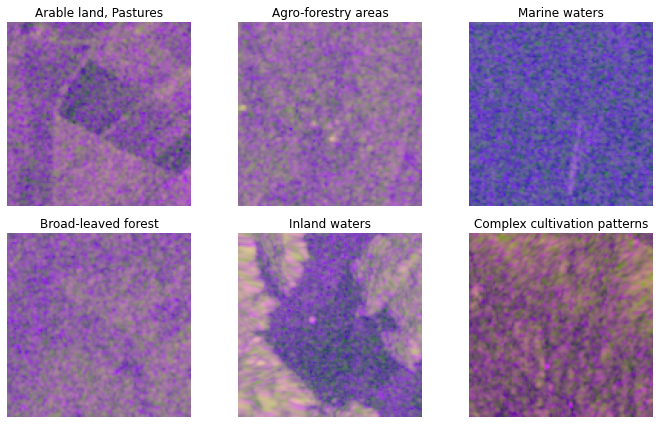

In [25]:
# Create a figure and axis for 6 images (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each image and plot it with a title
for i in range(6):
    axes[i].imshow(normalize_to_rgb(images[i]))
    axes[i].set_title(titles[i])
    axes[i].axis('off')  # Optional: hide axes ticks

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

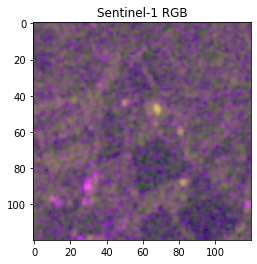

In [17]:
plt.imshow(normalize_to_rgb(s1_rgb))
plt.title("Sentinel-1 RGB")
plt.show()

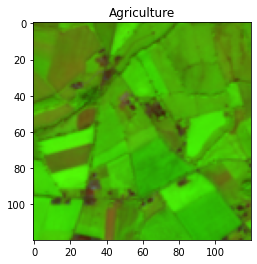

In [18]:
plt.imshow(normalize_to_rgb(s2_agri))
plt.title("Agriculture")
plt.show()

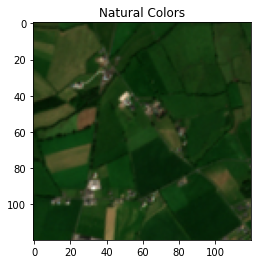

In [19]:
plt.imshow(normalize_to_rgb(s2_rgb))
plt.title("Natural Colors")
plt.show()

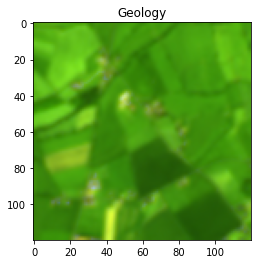

In [21]:
plt.imshow(normalize_to_rgb(s2_geology))
plt.title("Geology")
plt.show()

In [3]:
train_folder = 'D:\RSCode\Train_dataset\images'
test_folder = 'D:\RSCode\Test_dataset\images'

In [ ]:
for _, row in tqdm(train_portugal_df.iterrows()):
    s1_patch = row['s1_name']
    s2_patch = row['patch_id']
    s1_tile = extract_tile_from_patch(s1_patch, 3) 
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    s1_s2_raster, raster_profile = combine_s2_s1_bands(s2_patch_path, s1_patch_path)
            
    output_path = os.path.join(train_folder, s2_patch + '.tif')
    profile = raster_profile.copy()
    profile.update({
        'driver': 'GTiff',
        'dtype': s1_s2_raster.dtype,
        'count': s1_s2_raster.shape[0],  # number of bands
        'height': s1_s2_raster.shape[1],
        'width': s1_s2_raster.shape[2],
    })

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(s1_s2_raster)
        


In [32]:
for _, row in tqdm(test_portugal_df.iterrows()):
    s1_patch = row['s1_name']
    s2_patch = row['patch_id']
    s1_tile = extract_tile_from_patch(s1_patch, 3) 
    s2_tile = extract_tile_from_patch(s2_patch, 2) 
    s1_patch_path = os.path.join(s1_folder, s1_tile, s1_patch)
    s2_patch_path = os.path.join(s2_folder, s2_tile, s2_patch)
    s1_s2_raster, raster_profile = combine_s2_s1_bands(s2_patch_path, s1_patch_path)
            
    output_path = os.path.join(test_folder, s2_patch + '.tif')
    profile = raster_profile.copy()
    profile.update({
        'driver': 'GTiff',
        'dtype': s1_s2_raster.dtype,
        'count': s1_s2_raster.shape[0],  # number of bands
        'height': s1_s2_raster.shape[1],
        'width': s1_s2_raster.shape[2],
    })

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(s1_s2_raster)
        

23209it [1:31:15,  4.24it/s]


In [13]:
test_files = os.listdir(test_folder)
print("Test files count: ", len(test_files))

Test files count:  23209


In [14]:
with rasterio.open(os.path.join(train_folder, train_files[32320])) as src:
    sample = src.read()
    print("Shape: ", sample.shape)
    s1_rgb = np.dstack(np.array([sample[0], sample[1], sample[0] - sample[1]]))
    s2_rgb = np.dstack(np.array([sample[5], sample[4], sample[3]]))

Shape:  (14, 120, 120)


In [27]:
with rasterio.open(os.path.join(test_folder, test_files[1500])) as src:
    sample = src.read()
    print("Shape: ", sample.shape)
    s1_rgb_test = np.dstack(np.array([sample[0], sample[1], sample[0] - sample[1]]))
    s2_rgb_test = np.dstack(np.array([sample[5], sample[4], sample[3]]))
    s2_agri_test = np.dstack(np.array([sample[12], sample[9], sample[3]]))

Shape:  (14, 120, 120)


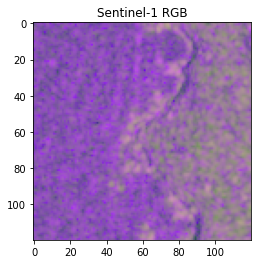

In [28]:
plt.imshow(normalize_to_rgb(s1_rgb))
plt.title("Sentinel-1 RGB")
plt.show()

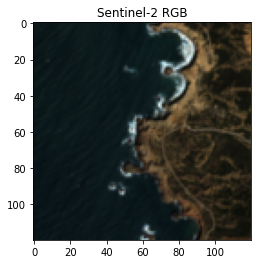

In [29]:
plt.imshow(normalize_to_rgb(s2_rgb))
plt.title("Sentinel-2 RGB")
plt.show()

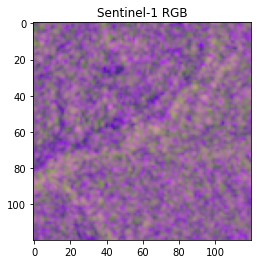

In [30]:
plt.imshow(normalize_to_rgb(s1_rgb_test))
plt.title("Sentinel-1 RGB")
plt.show()

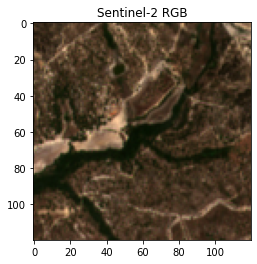

In [31]:
plt.imshow(normalize_to_rgb(s2_rgb_test))
plt.title("Sentinel-2 RGB")
plt.show()

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
all_labels = [
    "Urban fabric", "Industrial or commercial units", "Arable land", "Permanent crops", "Pastures",
    "Complex cultivation patterns", "Land principally occupied by agriculture, with significant areas of natural vegetation",
    "Agro-forestry areas", "Broad-leaved forest", "Coniferous forest", "Mixed forest",
    "Natural grassland and sparsely vegetated areas", "Moors, heathland and sclerophyllous vegetation",
    "Transitional woodland, shrub", "Beaches, dunes, sands", "Inland wetlands", "Coastal wetlands",
    "Inland waters", "Marine waters"
]

# Binarize the labels
mlb = MultiLabelBinarizer(classes=all_labels)
label_binarized = mlb.fit_transform(train_portugal_df['labels'])

label_df = pd.DataFrame(label_binarized, columns=mlb.classes_, index=train_portugal_df.index)
train_df = pd.concat([train_portugal_df, label_df], axis=1)
train_df = train_df.rename(columns={'patch_id': 's2_name'})
train_df.head()

,s2_name,s1_name,labels,Urban fabric,Industrial or commercial units,Arable land,Permanent crops,Pastures,Complex cultivation patterns,"Land principally occupied by agriculture, with significant areas of natural vegetation",...,Coniferous forest,Mixed forest,Natural grassland and sparsely vegetated areas,"Moors, heathland and sclerophyllous vegetation","Transitional woodland, shrub","Beaches, dunes, sands",Inland wetlands,Coastal wetlands,Inland waters,Marine waters
24732,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_0,"[Coniferous forest, Transitional woodland, shrub]",0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
24733,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_1,"[Coniferous forest, Transitional woodland, shrub]",0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
24734,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_2,"[Coniferous forest, Transitional woodland, shrub]",0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
24735,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_3,"[Coniferous forest, Transitional woodland, shrub]",0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
24736,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_0...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_0_4,"[Coniferous forest, Transitional woodland, shr...",1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
all_labels = [
    "Urban fabric", "Industrial or commercial units", "Arable land", "Permanent crops", "Pastures",
    "Complex cultivation patterns", "Land principally occupied by agriculture, with significant areas of natural vegetation",
    "Agro-forestry areas", "Broad-leaved forest", "Coniferous forest", "Mixed forest",
    "Natural grassland and sparsely vegetated areas", "Moors, heathland and sclerophyllous vegetation",
    "Transitional woodland, shrub", "Beaches, dunes, sands", "Inland wetlands", "Coastal wetlands",
    "Inland waters", "Marine waters"
]

# Binarize the labels
mlb = MultiLabelBinarizer(classes=all_labels)
label_binarized = mlb.fit_transform(test_portugal_df['labels'])

test_label_df = pd.DataFrame(label_binarized, columns=mlb.classes_, index=test_portugal_df.index)
test_df = pd.concat([test_portugal_df, test_label_df], axis=1)
test_df = test_df.rename(columns={'patch_id': 's2_name'})
test_df.head()

,s2_name,s1_name,labels,Urban fabric,Industrial or commercial units,Arable land,Permanent crops,Pastures,Complex cultivation patterns,"Land principally occupied by agriculture, with significant areas of natural vegetation",...,Coniferous forest,Mixed forest,Natural grassland and sparsely vegetated areas,"Moors, heathland and sclerophyllous vegetation","Transitional woodland, shrub","Beaches, dunes, sands",Inland wetlands,Coastal wetlands,Inland waters,Marine waters
26799,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_2...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_23_23,"[Complex cultivation patterns, Moors, heathlan...",0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
26800,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_2...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_23_24,"[Moors, heathland and sclerophyllous vegetatio...",0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
26801,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_2...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_23_25,"[Industrial or commercial units, Moors, heathl...",1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
26802,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_2...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_23_26,"[Permanent crops, Urban fabric]",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26803,S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_2...,S1A_IW_GRDH_1SDV_20170706T064235_29SND_23_27,"[Arable land, Industrial or commercial units, ...",1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# CLASS IMBALANCE ANALYSIS
class_counts = train_df.iloc[:, 3:].sum()  
print(class_counts)

Urban fabric                                                                               4088
Industrial or commercial units                                                             1396
Arable land                                                                               17081
Permanent crops                                                                           10956
Pastures                                                                                   5738
Complex cultivation patterns                                                               8605
Land principally occupied by agriculture, with significant areas of natural vegetation     7461
Agro-forestry areas                                                                       15082
Broad-leaved forest                                                                       13277
Coniferous forest                                                                          3599
Mixed forest                            

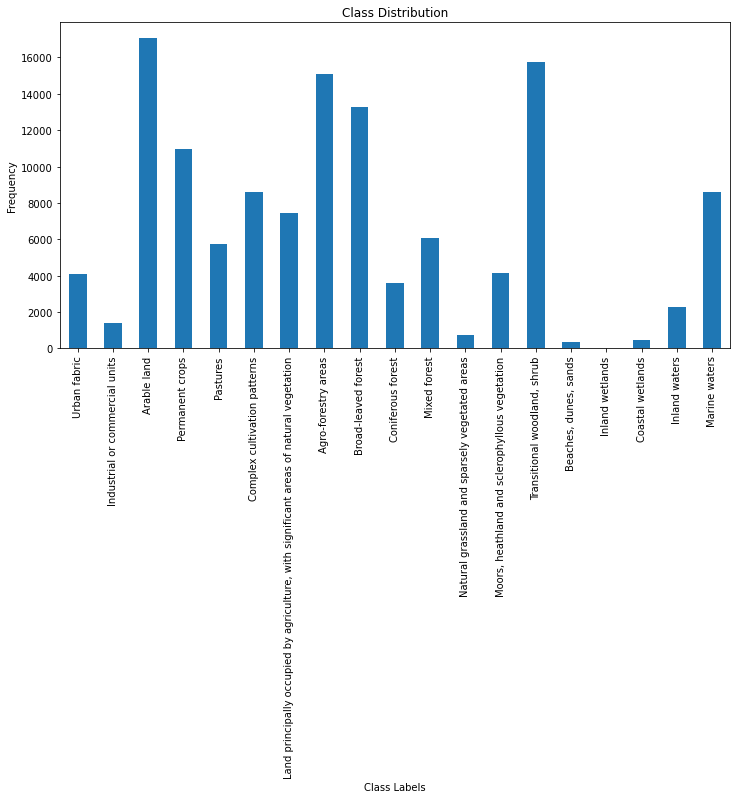

In [17]:
# Plotting the distribution of classes
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

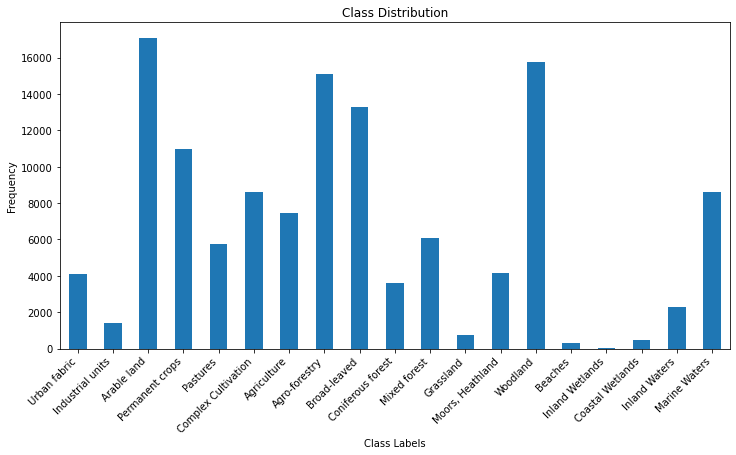

In [21]:
short_labels = {
    "Urban fabric": "Urban fabric",
    "Industrial or commercial units": "Industrial units",
    "Arable land": "Arable land",
    "Permanent crops": "Permanent crops",
    "Pastures": "Pastures",
    "Complex cultivation patterns": "Complex Cultivation",
    "Land principally occupied by agriculture, with significant areas of natural vegetation": "Agriculture",
    "Agro-forestry areas": "Agro-forestry",
    "Broad-leaved forest": "Broad-leaved",
    "Coniferous forest": "Coniferous forest",
    "Mixed forest": "Mixed forest",
    "Natural grassland and sparsely vegetated areas": "Grassland",
    "Moors, heathland and sclerophyllous vegetation": "Moors, Heathland",
    "Transitional woodland, shrub": "Woodland",
    "Beaches, dunes, sands": "Beaches",
    "Inland wetlands": "Inland Wetlands",
    "Coastal wetlands": "Coastal Wetlands",
    "Inland waters": "Inland Waters",
    "Marine waters": "Marine Waters"
}

# Rename the columns with shorter labels
df_short = train_df.rename(columns=short_labels)

# Recalculate class counts for the shortened labels
class_counts_short = df_short.iloc[:, 3:].sum()

# Plotting the distribution of classes with shortened labels
plt.figure(figsize=(12, 6))
class_counts_short.plot(kind='bar')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [25]:
output_csv_path = 'D:\RSCode\Train_dataset\labels.csv'
train_df.to_csv(output_csv_path, index=False)

output_csv_path = 'D:\RSCode\Test_dataset\labels.csv'
test_df.to_csv(output_csv_path, index=False)